## This analysis is to plot train test error cureve with varying complexity of model.
## Using KNNRegressor for this. Model complexity changes with change in lambda
- As complexity increases, model starts overfitting

## Based on Chapter 7 of ESL (Elements of statistical learning)

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV

In [4]:
from scipy.stats import loguniform, uniform

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.neighbors import KNeighborsRegressor

In [7]:
from mlxtend.evaluate import bias_variance_decomp

In [8]:
from sklearn.model_selection import RepeatedKFold

In [9]:
df = pd.read_csv("/Users/hardiksahi/Personal/Classical-Machine-Learning/classical-ml/notebooks/Data/Fish.csv")
print(f"Shape of df: {df.shape}")

Shape of df: (159, 7)


In [10]:
output_column_name = "Weight"

In [11]:
y = df[output_column_name]
X = df.drop(columns=[output_column_name])
print(f"Shape of y: {y.shape}")
print(f"Shape of X: {X.shape}")

Shape of y: (159,)
Shape of X: (159, 6)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (127, 6)
Shape of X_test: (32, 6)


In [13]:
categorical_col_list = X_train.select_dtypes(include='object').columns
print(f"categorical_col_list: {categorical_col_list}")

categorical_col_list: Index(['Species'], dtype='object')


In [14]:
numerical_col_list = X_train.select_dtypes(include='number').columns
print(f"numerical_col_list: {numerical_col_list}")

numerical_col_list: Index(['Length1', 'Length2', 'Length3', 'Height', 'Width'], dtype='object')


In [15]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler(with_mean=True, with_std=True))])
categorical_transformer = Pipeline(steps=[("one_hot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
preprocessor_pipeline = ColumnTransformer(transformers=[("cat", categorical_transformer, [0]), ("num", numeric_transformer, [1,2,3,4,5])])
# preprocessor_pipeline.set_output(transform="pandas")

In [16]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor_pipeline), ('regressor', KNeighborsRegressor())]) ## Ridge(fit_intercept=False)
# ridge_pipeline.set_output(transform="pandas")

In [17]:
# alpha_range = [1e-3, 1e-2, 1e-1, 1, 10, 50, 100, 200, 500, 1000, 2000, 5000]#loguniform.rvs(1e-5, 100, size=100)

In [18]:
params = {"regressor__n_neighbors": range(1,115, 1)}

In [19]:
model_cv = GridSearchCV(model_pipeline, params, return_train_score=True, cv=20, scoring=make_scorer(mean_squared_error, greater_is_better=True))

In [20]:
model_cv.fit(X_train, y_train)

GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('one_hot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         [0]),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         [1, 2,
                                                                          3, 4,
                                                                          5])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__n_neighbors': range(1, 115)},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, response_method='predict'))

In [21]:
model_cv_results_df = pd.DataFrame.from_records(model_cv.cv_results_)

In [22]:
score_df_list = []
for index, hyp in enumerate(model_cv.cv_results_["param_regressor__n_neighbors"]):
    train_score_list = []
    test_score_list = []
    split_list = []
    for split_id in range(model_cv.n_splits_):
        train_score_key = f"split{split_id}_train_score"
        test_score_key = f"split{split_id}_test_score"
        train_score_list.append(model_cv.cv_results_[train_score_key][index])
        test_score_list.append(model_cv.cv_results_[test_score_key][index])
        split_list.append(f"split{split_id}")
    train_score_for_param_df = pd.DataFrame({"prediction_error": train_score_list, "hyp": hyp, "dtype": "train", "split": split_list})
    test_score_for_param_df = pd.DataFrame({"prediction_error": test_score_list, "hyp": hyp, "dtype": "test", "split": split_list})
    score_df_list.append(train_score_for_param_df)
    score_df_list.append(test_score_for_param_df)
combined_score_df = pd.concat(score_df_list, axis=0)

In [23]:
combined_score_df = combined_score_df.sort_values(by=["hyp"], ascending=False)
combined_score_df["hyp"] = combined_score_df["hyp"].astype(str)

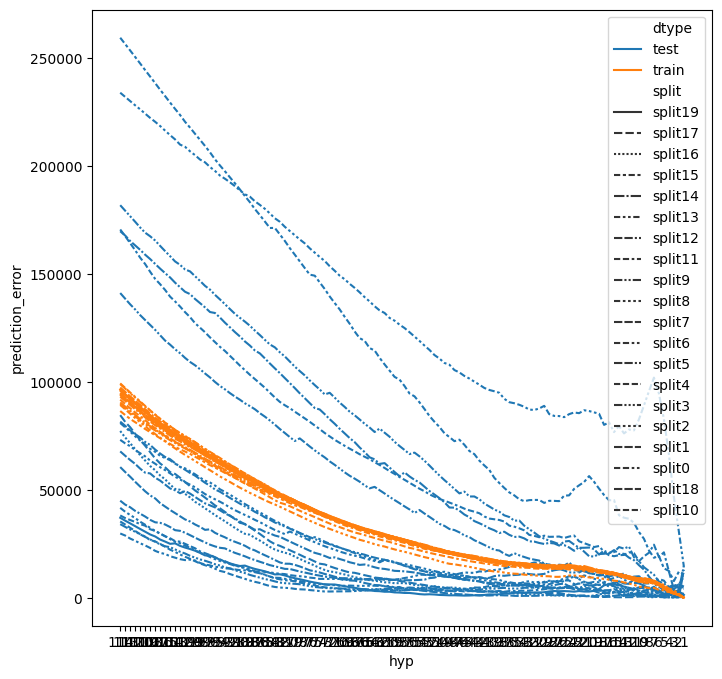

In [24]:
plt.figure(figsize=(8, 8))
sns.lineplot(data=combined_score_df, x="hyp", y="prediction_error", hue="dtype", style="split")
plt.show()

In [25]:
model_cv.best_params_

{'regressor__n_neighbors': 114}

In [26]:
model_cv.best_score_

np.float64(97150.35800652031)

In [27]:
mean_squared_error(y, [np.mean(y)]*len(y)) ## Dummy regressor that predicts mean worse then best model

127342.50986828053

In [28]:
model_cv.cv_results_["mean_test_score"][model_cv.best_index_] ## Expected Test error/ Expected prediction error

np.float64(97150.35800652031)

In [29]:
model_cv.cv_results_["mean_test_score"][0] ## Expected Test error/ Expected prediction error

np.float64(5148.703940476191)

## Perform bias variance decomposition of Mean Sqared Error for the entire model process (USING MLXTEND bootstrapping to get perturbations on train data):
1. Most complex when C=1
2. Least complex model when C=114

As expected, least complex (high bias, low variance leads to underfit) => most complex (low bias, high variance leads to overfit)

## Any loss function can be broken down into bias, variance and error terms. MSE loss is easier to derive mathematically. Thats is why it is preferred to do it

In [30]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        Pipeline(steps=[('preprocessor', preprocessor_pipeline), ('regressor', KNeighborsRegressor(n_neighbors=114))]), X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), 
        loss='mse',
        random_seed=123)
print(f"Least complex => Bias: {avg_bias}, Variance: {avg_var}, Expected loss: {avg_expected_loss}")

Least complex => Bias: 166574.5132416487, Variance: 967.8805696469774, Expected loss: 167542.39381129565


In [31]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        Pipeline(steps=[('preprocessor', preprocessor_pipeline), ('regressor', KNeighborsRegressor(n_neighbors=1))]), X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), 
        loss='mse',
        random_seed=123)
print(f"Most complex => Bias: {avg_bias}, Variance: {avg_var}, Expected loss: {avg_expected_loss}")

Most complex => Bias: 7120.213056476561, Variance: 5719.847923210938, Expected loss: 12840.060979687498


## Bias variance decomposition using custom function using bootstrapping

In [32]:
numpy_X_train = X_train.to_numpy()
numpy_y_train = y_train.to_numpy()
numpy_X_test = X_test.to_numpy()
numpy_y_test = y_test.to_numpy()

In [33]:
def regression_bias_variance_decomposition_using_bootstrap(regressor, X_train, y_train, X_test, y_test, num_rounds=200): ## X_test, y_test is fixed!!
    ## Need to get multiple datasets from X_train, y_train via bootstrapping
    ## Train model on bootstrapped dataset
    ## Predict on X_test and keep track of it

    def _draw_bootstrap_sample(rng, X, y):
        sample_indices = np.arange(X.shape[0])
        bootstrap_indices = rng.choice(
            sample_indices, size=sample_indices.shape[0], replace=True
        )
        return X[bootstrap_indices], y[bootstrap_indices]

    rng = np.random.RandomState(123)
    
    all_pred = np.zeros((num_rounds, y_test.shape[0]))
    all_train_pred = np.zeros((num_rounds, y_train.shape[0]))
    
    for i in range(num_rounds):
        boot_X, boot_y = _draw_bootstrap_sample(rng, X_train, y_train) ## Bootstrapped dataset on X_train, y_train

        ## Train regressor on boot_X, boot_ys
        regressor.fit(boot_X, boot_y)

        ## Predict 
        train_predictions = regressor.predict(boot_X)
        test_predictions = regressor.predict(X_test)
        #all_train_pred[i] = train_predictions
        all_pred[i] = test_predictions
        

    ## Get expected test error/ expected prediction error
    expected_test_error = np.mean(np.sum((all_pred - y_test)**2, axis=1)/y_test.shape[0]) ## Expected prediction error Expected MSE across multiple datasets across all point
    #expected_train_error = np.mean(np.sum((all_train_pred - y_train)**2, axis=1)/y_train.shape[0]) ## Expected train error
    

    ## Get bias and variance (need to ensure same test sample)
    average_prediction_for_test_date = np.mean(all_pred, axis=0)
    bias_sq_for_each_point = (average_prediction_for_test_date-y_test)**2 ## Bias for each data point in test set
    average_bias_across_all_points = np.mean(bias_sq_for_each_point) ## Average bias across all data points

    variance_for_each_point = np.mean((average_prediction_for_test_date-all_pred)**2, axis=0)
    average_variance_across_all_points = np.mean(variance_for_each_point)

    mse_for_each_point = np.mean((all_pred - y_test)**2, axis=1)
    average_mse_across_all_points = np.mean(mse_for_each_point) ## Exactly same as expected_test_error

    info_average_across_all_points_dict = {"expected_test_error": expected_test_error, "average_bias_across_all_points": average_bias_across_all_points, "average_variance_across_all_points": average_variance_across_all_points, "average_mse_across_all_points": average_mse_across_all_points}
    info_for_each_point_dict = {"test_error": mse_for_each_point, "bias": bias_sq_for_each_point, "variance": variance_for_each_point, "mse": mse_for_each_point}

    return info_average_across_all_points_dict, info_for_each_point_dict

In [34]:
overfit_info_average_mse_across_all_points, overfit_info_for_each_point_dict = regression_bias_variance_decomposition_using_bootstrap(Pipeline(steps=[('preprocessor', preprocessor_pipeline), ('regressor', KNeighborsRegressor(n_neighbors=2))]), numpy_X_train, numpy_y_train, numpy_X_test, numpy_y_test)

In [35]:
overfit_info_average_mse_across_all_points["expected_test_error"], overfit_info_average_mse_across_all_points["average_bias_across_all_points"], overfit_info_average_mse_across_all_points["average_variance_across_all_points"], overfit_info_average_mse_across_all_points["average_mse_across_all_points"]

(np.float64(16421.460545703125),
 np.float64(10783.211219298828),
 np.float64(5638.24932640429),
 np.float64(16421.460545703125))

In [36]:
# print(f"Expected train error: {overfit_info_average_mse_across_all_points['expected_train_error']}")

In [37]:
## This is for analysing mse, bias and var for each data point => mse != bias**2 + var for each data point
## For this case, this is also the best model
overfit_case_sigma2 = [mse - (bias+var) for mse, bias, var in zip(overfit_info_for_each_point_dict["mse"], overfit_info_for_each_point_dict["bias"], overfit_info_for_each_point_dict["variance"])]

In [38]:
underfit_info_average_mse_across_all_points, underfit_info_for_each_point_dict = regression_bias_variance_decomposition_using_bootstrap(Pipeline(steps=[('preprocessor', preprocessor_pipeline), ('regressor', KNeighborsRegressor(n_neighbors=114))]), numpy_X_train, numpy_y_train, numpy_X_test, numpy_y_test)

In [39]:
underfit_info_average_mse_across_all_points["expected_test_error"], underfit_info_average_mse_across_all_points["average_bias_across_all_points"], underfit_info_average_mse_across_all_points["average_variance_across_all_points"], underfit_info_average_mse_across_all_points["average_mse_across_all_points"]

(np.float64(167542.39381129565),
 np.float64(166574.5132416487),
 np.float64(967.8805696469774),
 np.float64(167542.39381129565))

In [40]:
# print(f"Expected train error: {underfit_info_average_mse_across_all_points['expected_train_error']}")

In [41]:
underfit_case_sigma2 = [mse - (bias+var) for mse, bias, var in zip(underfit_info_for_each_point_dict["mse"], underfit_info_for_each_point_dict["bias"], underfit_info_for_each_point_dict["variance"])]

In [42]:
sigma2_df = pd.concat([pd.DataFrame({"sigma2":overfit_case_sigma2, "case": "overfit"}), pd.DataFrame({"sigma2":underfit_case_sigma2, "case": "underfit"})], axis=0)

<Axes: xlabel='sigma2', ylabel='Count'>

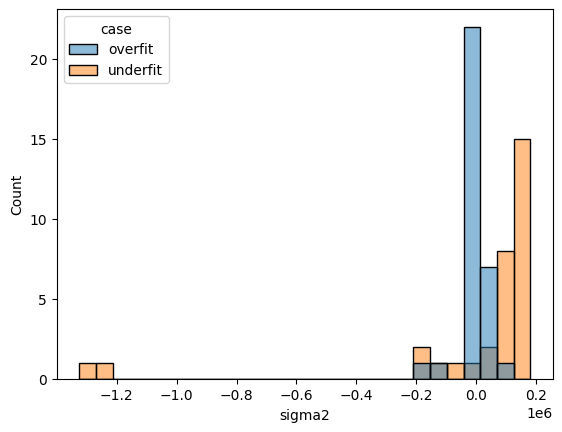

In [43]:
sns.histplot(data=sigma2_df, x="sigma2", hue="case")

<Axes: xlabel='case', ylabel='sigma2'>

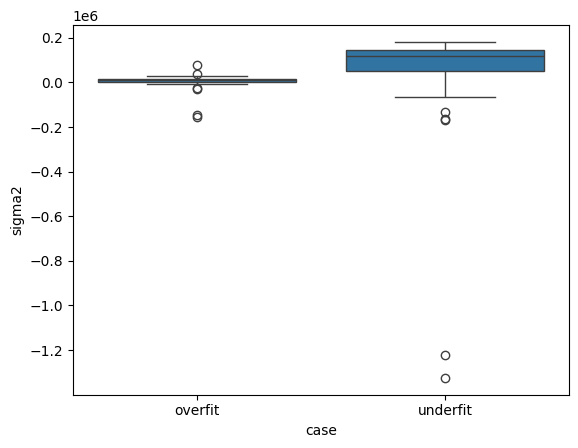

In [44]:
sns.boxplot(data=sigma2_df, y="sigma2", x="case")

## Expected test error/ prediction error (averaged at X, y and different training datasets) = Average bias**2 (averaged across all data points in test set) + Average Var (averaged across all data points in test set)

In [45]:
np.isclose(expected_test_error, average_bias_across_all_points + average_variance_across_all_points)

NameError: name 'expected_test_error' is not defined

In [ ]:
np.sqrt(average_bias_across_all_points)

## Links:
1. https://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/ (Functionality to perform bias variance decomposition of MSE for regressor and 0-1 loss for classifers)
2. https://stdm.github.io/downloads/courses/ML/V06_BiasVariance-LearningCurves.pdf
3. https://codesachin.wordpress.com/2015/08/30/cross-validation-and-the-bias-variance-tradeoff-for-dummies/